In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from pathlib import Path
from random import sample
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy
from torch.optim import lr_scheduler

from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import albumentations as A

In [2]:
from steinbock import io

import helpers

# **Islet segmentation**

Notebook to train an islet segmentation model based on U-Net.

## **Settings**

### Folders

Images and masks have been generated using the `data_formatting.ipynb` notebook.
They can directly be **DOWNLOADED FROM ZENODO (UPDATE)** and stored in the `DIR_IMAGES` and `DIR_MASKS` folder, respectively.

In [3]:
#DIR_DATA = Path("/home/ubuntu/Data2/islet_segmentation/")
DIR_DATA = Path("/home/processing/islet_segmentation/")
assert Path.exists(DIR_DATA), f"{DIR_DATA} does not exist"

DIR_IMAGES = DIR_DATA / "images"
DIR_MASKS = DIR_DATA / "masks"
DIR_IMAGES.mkdir(exist_ok=True)
DIR_MASKS.mkdir(exist_ok=True)

### Model hyper-parameters

View other segmentation models, encoders and loss functions:
https://smp.readthedocs.io/en/latest/index.html

In [4]:
IMG_SIZE = 160
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.003
DEVICE = "cpu"
SEED = 42

## **Process input data**

### **Summarize training data**

In [5]:
input_images = sorted([x.name for x in DIR_IMAGES.iterdir() if x.name.endswith(".png")])
input_masks = sorted([x.name for x in DIR_MASKS.iterdir() if x.name.endswith(".png")])

assert len(input_images) == len(input_masks), f"The number of input images and masks should be the same."
print("Number of images:", len(input_images))

In [6]:
# Create a data frame
df = pd.DataFrame({"images": input_images, "masks": input_masks,
                  "dir_images": DIR_IMAGES, "dir_masks": DIR_MASKS})
print("Are image and mask names the same?", df["images"].equals(df["masks"]))

# Add Case IDs and Panels
df_meta = df.images.str.split("_", n = 0, expand = True)
df["case_id"] = df_meta[0]
df["panel"] = df_meta[1]
df

## **Prepare training and test sets**

### **Split training / test**

In [7]:
train_df, test_df = train_test_split(
    df,
    test_size = 0.33,
    stratify = df[["case_id", "panel"]],
    random_state = SEED
)

### **Data augmentation**

See the `get_train_augmentations()` and `get_test_augmentations()` functions in the `helpers.py` file.

Data augmentation is performed with [Albumentations](https://albumentations.ai/).

### **Create dataset class**

See the `IsletDataset()` class in the `helpers.py` file.

### **Generate the training and test sets**

In [8]:
train_set = helpers.IsletDataset(train_df, helpers.get_train_augmentations(IMG_SIZE))
test_set = helpers.IsletDataset(test_df, helpers.get_test_augmentations(IMG_SIZE))

print(f"Training set size : {len(train_set)}")
print(f"Test set size : {len(test_set)}")

### **Plot training data**

In [9]:
img_to_plot = 5
idxes = sample(range(0, len(train_set)), img_to_plot)

fig, axs = plt.subplots(img_to_plot, 2, figsize=(8, 4*img_to_plot))

for i, idx in enumerate(idxes):
    image, mask = train_set[idx]

    axs[i,0].set_title('Images')
    axs[i,0].imshow(image.permute(1,2,0).squeeze())

    axs[i,1].set_title('Masks')
    axs[i,1].imshow(mask.permute(1,2,0).squeeze())

# Save plot
plt.savefig(DIR_DATA / "ground_truth_masks_islets.png")
plt.show()

### **Load dataset into batches**

In [10]:
train_loader = helpers.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = helpers.DataLoader(test_set, batch_size = BATCH_SIZE)

In [11]:
print(f"Number of batches in training loader : {len(train_loader)}")
print(f"Number of batches in test loader : {len(test_loader)}")

In [12]:
for image, mask in train_loader:
    print(f"Shape of image batches: {image.shape}")
    print(f"Shape of mask batches : {mask.shape}")
    break

## **Create islet segmentation model**

### **Create the model**

See `IsletModel` in the `helpers.py` file.

In [13]:
model = helpers.IsletModel()
model.to(DEVICE);

### **Create evaluation functions**

See the `training_function` and `evaluation_function` in the `helpers.py` file.

## **Train the model**

In [14]:
# Train the Model using the Adam optimizer. 
# This runs for around 60 min on my remote machine (16 CPUs, 64 GB RAM, no GPU, 10 Epochs). 
# Adding GPU yields speed-up of around ~ 2x.

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [15]:
best_test_loss = np.Inf
train_losses = []
test_losses = []
test_accuracy = []
test_f1_scores = []

# Train the model; each iteration is an epoch.
for i in range(EPOCHS):
    # Train the model; retrieve test and train loss.
    train_loss = helpers.training_function(data_loader = train_loader, model = model, optimizer = optimizer, device = DEVICE)
    test_loss, test_acc, test_f1 = helpers.evaluation_function(test_loader, model, DEVICE)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    test_f1_scores.append(test_f1)
    
    # Print the losses
    print(f"Epoch {i+1} - Train loss = {train_loss}, Test loss = {test_loss}, Accuracy = {test_acc}, f1_score = {test_f1}")

    # Save the model if the test loss is less than our current best
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), DIR_DATA / "islet_model.pt")
        print("The model was saved")    

100%|██████████| 80/80 [01:16<00:00,  1.05it/s]


Epoch 1 - Train loss = 0.16810360688854148, Test loss = 0.07608597641810774, Accuracy = 0.9871889352798462, f1_score = 0.96644127368927
The model was saved


100%|██████████| 80/80 [01:06<00:00,  1.20it/s]


Epoch 2 - Train loss = 0.10039204230279099, Test loss = 0.07823260109871626, Accuracy = 0.9863664507865906, f1_score = 0.9646109342575073


100%|██████████| 80/80 [01:04<00:00,  1.24it/s]


Epoch 3 - Train loss = 0.09596268883273926, Test loss = 0.0737185322213918, Accuracy = 0.9872268438339233, f1_score = 0.9669750332832336
The model was saved


100%|██████████| 80/80 [01:02<00:00,  1.28it/s]


Epoch 4 - Train loss = 0.09368313080918642, Test loss = 0.06835258058272302, Accuracy = 0.9881022572517395, f1_score = 0.9689685106277466
The model was saved


100%|██████████| 80/80 [01:03<00:00,  1.27it/s]


Epoch 5 - Train loss = 0.08944544738825456, Test loss = 0.07524232068099082, Accuracy = 0.9869371652603149, f1_score = 0.9657092094421387


100%|██████████| 80/80 [01:04<00:00,  1.24it/s]


Epoch 6 - Train loss = 0.08971380366495361, Test loss = 0.06948260692879557, Accuracy = 0.987860381603241, f1_score = 0.9684659242630005


100%|██████████| 80/80 [01:07<00:00,  1.18it/s]


Epoch 7 - Train loss = 0.08937157593943455, Test loss = 0.07276278627105057, Accuracy = 0.987514317035675, f1_score = 0.9674530029296875


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


Epoch 8 - Train loss = 0.08784662610218849, Test loss = 0.06856989138759673, Accuracy = 0.9879497289657593, f1_score = 0.9685715436935425


100%|██████████| 80/80 [01:01<00:00,  1.30it/s]


Epoch 9 - Train loss = 0.08489153134050192, Test loss = 0.07280355016700923, Accuracy = 0.9872375726699829, f1_score = 0.9666706323623657


100%|██████████| 80/80 [01:01<00:00,  1.30it/s]

Epoch 10 - Train loss = 0.08298742844734663, Test loss = 0.07572296196594834, Accuracy = 0.9868963956832886, f1_score = 0.9663883447647095


In [16]:
# Plot the losses
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Test loss")
plt.legend()
# Save the image.
plt.savefig(DIR_DATA / "UNet_losses.png")
plt.show()

Note: the difference between test & train loss is most likely due to the application of data augmentation and dropout layers only to the train dataset. 

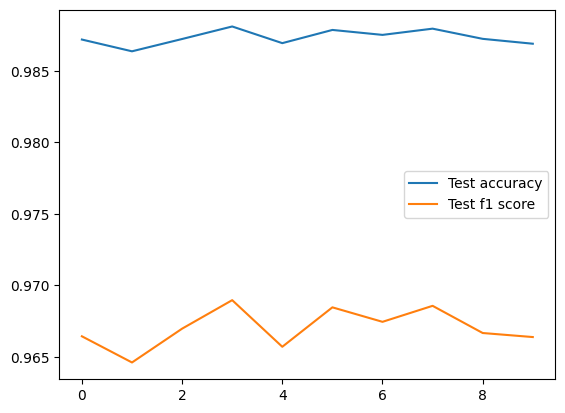

In [17]:
c_accuracy_list = [x.cpu().item() for x in test_accuracy]
c_f1_list = [x.cpu().item() for x in test_f1_scores]

plt.plot(c_accuracy_list, label = "Test accuracy")
plt.plot(c_f1_list, label = "Test f1 score")
plt.legend()

# Save the image.
plt.savefig(DIR_DATA / "UNet_accuracy_f1.png")
plt.show()

## **Infer**
### Load the model

In [18]:
# Load the model
model.load_state_dict(torch.load(DIR_DATA / "islet_model.pt"))
print(f"The device is: {DEVICE}")

Infer masks on the test set and plot.

In [20]:
img_to_plot = 25
idxes = sample(range(0, len(test_set)), img_to_plot)

fig, axs = plt.subplots(img_to_plot, 3, figsize=(8, 4*img_to_plot))

for i, idx in enumerate(idxes):
    
    # Image and ground truth
    image, mask = test_set[idx]
    
    # Predicted mask
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # c,y,x -> 1,c,y,x
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = torch.detach(pred_mask)
    pred_mask = (pred_mask > 0.5) * 255.0
    
    # Plot
    axs[i,0].set_title('Images')
    axs[i,0].imshow(image.squeeze())

    axs[i,1].set_title('Ground truth')
    axs[i,1].imshow(mask.squeeze())
    
    axs[i,2].set_title('Predicted mask')
    axs[i,2].imshow(pred_mask.squeeze())

plt.savefig(DIR_DATA / "UNet_predictions.png")
plt.show()